**INTRODUCTION**

Hi, in this notebook, I'll create a very simple anime recommendation system based on ratings and genre.
let's get started by importing necessary library and the dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [4]:
df = pd.read_csv('rating.csv')

In [5]:
anime = pd.read_csv('anime.csv')

**PART 1. DATA PREPROCESSING**

First, I'll merge the user rating dataframe with anime dataframe in order to get anime name

In [6]:
df = pd.merge(df,anime.drop('rating',axis=1),on='anime_id')

In [7]:
df.head()

,user_id,anime_id,rating,name,genre,type,episodes,members
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
1,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
2,5,20,6,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
3,6,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
4,10,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297


now, let's check anime by its rating

In [8]:
df.groupby('name')['rating'].mean().sort_values(ascending=False).head(10)

name
Shiroi Zou                                                          10.000000
Choegang Top Plate                                                  10.000000
Warui no wo Taose!! Salaryman Man                                   10.000000
STAR BEAT!: Hoshi no Kodou                                          10.000000
Doukyuusei                                                           9.000000
Yakushiji Ryouko no Kaiki Jikenbo: Hamachou, Voice &amp; Fiction     9.000000
Shiranpuri                                                           9.000000
Tang Lang Bu Chan                                                    9.000000
Steins;Gate 0                                                        8.500000
Kimi no Na wa.                                                       8.297863
Name: rating, dtype: float64

Hmmm... seems something's not right here. maybe that animes with 10 rating only got a few users watched them so the rating goes up so high.

so, we need another attribute in order to get better recommendation. **number of users** seems logical since the more users watched the anime, higher probability the anime gets the actual rating based on many users.

let's check it out

In [9]:
df.groupby('name')['rating'].count().sort_values(ascending=False).head(10)

name
Death Note                          39340
Sword Art Online                    30583
Shingeki no Kyojin                  29584
Code Geass: Hangyaku no Lelouch     27718
Elfen Lied                          27506
Angel Beats!                        27183
Naruto                              25925
Fullmetal Alchemist                 25032
Fullmetal Alchemist: Brotherhood    24574
Toradora!                           24283
Name: rating, dtype: int64

Now we see some popular anime here, like **Shingeki No Kyojin, Naruto, and even Fullmetal Alchemist** (*I've watched all of them though, except Code Geass and Elfen Lied, maybe I should add them to my watchlist*)

**PART 2. EXPLORATORY DATA ANALYSIS**

Let's do a very simple EDA.

In [10]:
ratings = pd.DataFrame(df.groupby('name')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('name')['rating'].count())

genre_dict = pd.DataFrame(data=anime[['name','genre']])
genre_dict.set_index('name',inplace=True)

In [11]:
ratings.head()

,rating,num of ratings
name,,
&quot;0&quot;,2.769231,26
"&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",0.000000,2
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,5.774936,782
&quot;Bungaku Shoujo&quot; Memoire,6.155748,809
&quot;Bungaku Shoujo&quot; Movie,6.457980,1535


Now let's check anime number of ratings distribution

(0, 3000)

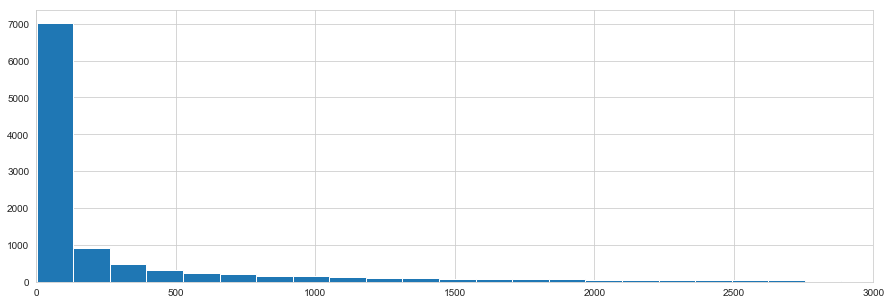

In [12]:
plt.figure(figsize=(15,5))
ratings['num of ratings'].hist(bins=300)
plt.xlim(0,3000)

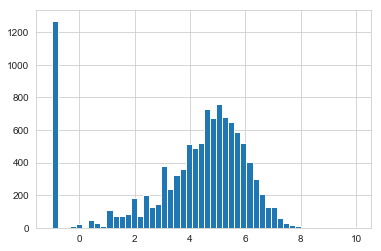

In [13]:
ratings['rating'].hist(bins=50)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


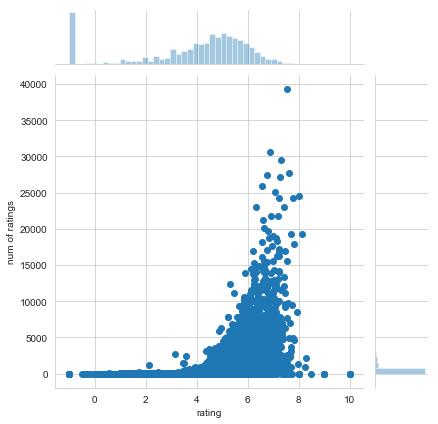

In [14]:
sns.jointplot(x='rating',y='num of ratings',data=ratings)

From above scatterplot, we can see the higher number of users give rating, higher chance of the anime gets high rating too.

**PART 3. FUNCTION CREATION**

Now I'll create the function to be executed when a user accessing an anime page on myanimelist, so that user can get the recommendation based on that anime. This recommendation will be generated based on ratings and genre

In [31]:
def check_genre(genre_list,string):
    if any(x in string for x in genre_list):
        return True
    else:
        return False
    
def get_recommendation(name):
    #generating list of anime with the same genre with target
    anime_genre = genre_dict.loc[name].values[0].split(', ')
    cols = anime[anime['genre'].apply(
        lambda x: check_genre(anime_genre,str(x)))]['name'].tolist()
    
    #create matrix based on generated list
    animemat = df[df['name'].isin(cols)].pivot_table(
        index='user_id',columns='name',values='rating')
       
    #create correlation table
    anime_user_rating = animemat[name]
    similiar_anime = animemat.corrwith(anime_user_rating)
    corr_anime = pd.DataFrame(similiar_anime,columns=['correlation'])
    corr_anime = corr_anime.join(ratings['num of ratings'])
    corr_anime.dropna(inplace=True)
    corr_anime = corr_anime[corr_anime['num of ratings']>5000].sort_values(
        'correlation',ascending=False)
    
    return corr_anime.head(10)

**PART 4. TESTING**

In [16]:
get_recommendation('Shingeki no Kyojin')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,correlation,num of ratings
name,,
Shingeki no Kyojin,1.000000,29584
Suisei no Gargantia,0.752774,6371
Kami nomi zo Shiru Sekai: Megami-hen,0.750020,5733
Blood Lad,0.741779,8507
Hitsugi no Chaika,0.736769,5168
Maoyuu Maou Yuusha,0.732879,5693
Danganronpa: Kibou no Gakuen to Zetsubou no Koukousei The Animation,0.728270,10082
Magi: The Labyrinth of Magic,0.726442,9907
Psycho-Pass,0.726120,14008


In [22]:
get_recommendation('Kimi no Na wa.')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,correlation,num of ratings
name,,
School Days,0.375831,12417
Digimon Adventure 02,0.404384,6670
Lucky☆Star: Original na Visual to Animation,0.442872,5089
Arakawa Under the Bridge,0.446791,5732
Angel Beats!: Another Epilogue,0.451882,7032
Mobile Suit Gundam 00,0.451953,5196
InuYasha,0.457565,9328
Naruto Movie 2: Dai Gekitotsu! Maboroshi no Chiteiiseki Dattebayo!,0.458342,6296
Onegai☆Teacher,0.459813,5489


In [30]:
get_recommendation('Naruto')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,correlation,num of ratings
name,,
Naruto,1.000000,25925
Bleach,0.720531,12845
InuYasha,0.704638,9328
Shaman King,0.696407,7814
Katekyo Hitman Reborn!,0.694202,6739
Tenjou Tenge,0.691476,5150
Sekirei,0.691413,7924
Rurouni Kenshin: Meiji Kenkaku Romantan,0.690855,7900
Shijou Saikyou no Deshi Kenichi,0.690250,5654


In [19]:
get_recommendation('Mushishi')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,correlation,num of ratings
name,,
Mushishi,1.000000,7004
D-Frag!,0.728374,5124
Samurai Champloo,0.720465,14068
Natsume Yuujinchou,0.720205,6052
Hitsugi no Chaika,0.711976,5168
Arakawa Under the Bridge,0.710618,5732
Ghost in the Shell: Stand Alone Complex,0.706540,6329
Kami nomi zo Shiru Sekai: Megami-hen,0.706520,5733
Kami nomi zo Shiru Sekai II,0.705563,9235


In [20]:
get_recommendation('Noragami')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,correlation,num of ratings
name,,
Noragami,1.000000,15070
Hitsugi no Chaika,0.798425,5168
Kami nomi zo Shiru Sekai: Megami-hen,0.792456,5733
Kyoukai no Kanata,0.791119,11152
Suisei no Gargantia,0.789261,6371
Nisekoi,0.784901,10337
Magi: The Kingdom of Magic,0.783770,7279
Strike the Blood,0.776561,6434
Monogatari Series: Second Season,0.776080,6058
